## Sepehr Rezaee - 99242067

### For implementing the steps for JPEG compression, we do this steps:
<ul>
    <li>Step 1: Convert the image from the RGB color space to the YCbCr color space</li>
    <li>Step 2: Divide the image into 8x8 blocks</li>
    <li>Step 3: Apply the Discrete Cosine Transform (DCT) to each block</li>
    <li>Step 4: Quantize each block using a quantization matrix</li>
    <li>Step 5: Perform zigzag ordering on each block</li>
    <li>Step 6: Apply entropy encoding (e.g., Huffman encoding) to the resulting data</li>
    <li>Step 7: Return the compressed data</li>
</ul>

### And for decompression, we implement the below steps:
<ul>
    <li>Step 1: Perform entropy decoding (e.g., Huffman decoding) on the compressed data</li>
    <li>Step 2: Reorder the data using the inverse zigzag ordering</li>
    <li>Step 3: Dequantize each block using the quantization matrix</li>
    <li>Step 4: Apply the Inverse Discrete Cosine Transform (IDCT) to each block</li>
    <li>Step 5: Combine the 8x8 blocks to reconstruct the image</li>
    <li>Step 6: Convert the image from the YCbCr color space back to the RGB color space</li>
    <li>Step 7: Return the compressed data</li>
</ul>

### Import dependencies

In [2]:
import os
import cv2
import sys
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
def resize_img(img, num=8):
    # Get the original image size
    height, width, _ = img.shape

    # Calculate new dimensions that are divisible by num
    new_height = (height // num) * num
    new_width = (width // num) * num

    # Resize the image using OpenCV's resize function
    resized_img = cv.resize(img, (new_width, new_height))

    return resized_img

def img_blocks(image):
    num_rows, num_cols = image.shape[:2]
    
    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    # Create empty list to hold blocks
    blocks = []
    
    # Iterate over each block
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8
            
            start_y = y * 8
            end_y = start_y + 8
            
            # Extract block from image
            block = image[start_y:end_y, start_x:end_x]
            
            # Add block to list of blocks
            blocks.append(block)
    
    return blocks

def recon_blocks(blocks, image_shape):
    # Get dimensions of the image
    num_rows, num_cols = image_shape[:2]
    
    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    # Create empty array to hold image
    image = np.zeros(image_shape, dtype=np.uint8)
    
    # Iterate over each block
    block_index = 0
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8
            
            start_y = y * 8
            end_y = start_y + 8
            
            # Extract block from list of blocks
            block = blocks[block_index]
            block_index += 1
            
            # Insert block into image
            image[start_y:end_y, start_x:end_x] = block
    
    return image

def dct(blocks):
    dcts = []
    for block in blocks:
        dct = np.stack([cv2.dct(np.float32(block[:,:,i])) for i in range(block.shape[2])], axis=2)
        dcts.append(dct)
    return dcts

def inv_dct(dct_blocks):
    blocks = []
    for dct_block in dct_blocks:
        block = np.stack([cv2.idct(np.float32(dct_block[:,:,i])) for i in range(dct_block.shape[2])], axis=2)
        blocks.append(block)
    return blocks

def quantize(blocks, lossie=1):
    quantization_table = lossie * np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
    quantized = []
    for block in blocks:
        dct_quantized = np.stack([np.round(block[:,:,i] / quantization_table) for i in range(block.shape[2])], axis=2)
        quantized.append(dct_quantized)
    return quantized, quantization_table

def dequantize(quantized_blocks, quantization_table):
    blocks = []
    for quantized_block in quantized_blocks:
        dct_dequantized = np.stack([np.round(quantized_block[:,:,i] * quantization_table) for i in range(quantized_block.shape[2])], axis=2)
        blocks.append(dct_dequantized)
    return blocks

def zigzag(blocks):
    zigzag_order = np.array([
    [ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]])

    ordered_blocks = []
    flatten_orders = zigzag_order.flatten()
    for block in blocks:
        y, cb, cr = block[:,:,0].flatten(), block[:,:,1].flatten(), block[:,:,2].flatten()
        y_ordered = y[flatten_orders]
        cb_ordered = cb[flatten_orders]
        cr_ordered = cr[flatten_orders]
        ordered_blocks.append(np.stack([y_ordered,cb_ordered, cr_ordered,], axis=1))
    return ordered_blocks

def dezigzag(ordered_blocks):
    zigzag_order = np.array([
        [ 0,  1,  5,  6, 14, 15, 27, 28],
        [ 2,  4,  7, 13, 16, 26, 29, 42],
        [ 3,  8, 12, 17, 25, 30, 41, 43],
        [ 9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]])

    blocks = []
    flatten_orders = zigzag_order.flatten()
    for ordered_block in ordered_blocks:
        y_ordered, cb_ordered, cr_ordered = ordered_block[:,0], ordered_block[:,1], ordered_block[:,2]
        y = np.zeros((64,))
        cb = np.zeros((64,))
        cr = np.zeros((64,))
        y[flatten_orders] = y_ordered
        cb[flatten_orders] = cb_ordered
        cr[flatten_orders] = cr_ordered
        y = np.reshape(y, (8, 8))
        cb = np.reshape(cb, (8, 8))
        cr = np.reshape(cr, (8, 8))
        block = np.stack([y, cb, cr], axis=2)
        blocks.append(block)
    return blocks

def huffman_encode(arr):
    # Count the frequency of each integer in the array.
    freq = defaultdict(int)
    for num in arr:
        freq[num] += 1
    
    # Build a Huffman tree from the frequencies.
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    # Generate the Huffman codes for each integer.
    huffman_codes = dict(heapq.heappop(heap)[1:])
    
    # Encode the array using the Huffman codes.
    encoded_arr = ""
    for num in arr:
        encoded_arr += huffman_codes[num]
    
    return encoded_arr, huffman_codes

def huffman_decode(encoded_arr, huffman_codes):
    # Invert the Huffman codes dictionary.
    inv_huffman_codes = {v: k for k, v in huffman_codes.items()}
    if encoded_arr == "":
        return np.zeros(64)
    # Decode the array using the inverted Huffman codes.
    decoded_arr = []
    code = ""
    for bit in encoded_arr:
        code += bit
        if code in inv_huffman_codes:
            decoded_arr.append(inv_huffman_codes[code])
            code = ""
    
    return np.array(decoded_arr)


def huffman_encode_matrix(matrix):
    # Initialize list to store encoded data for each channel
    encoded_channels = []
    code_dicts = []
    # Loop through each channel in the matrix
    for i in range(matrix.shape[1]):
        # Extract the channel as a 1D array
        arr = matrix[:,i]

        # Encode the input data using Huffman coding
        encoded_arr, code_dict = huffman_encode(arr)

        # Append the encoded data and code dictionary to the list of encoded channels
        encoded_channels.append(encoded_arr)
        code_dicts.append(code_dict)
    
    return encoded_channels, code_dicts

def huffman_decode_matrix(encoded_channels, code_dicts):
    # Initialize matrix to store decoded data
    decoded_matrix = np.zeros((64, len(encoded_channels)), dtype=np.uint8)

    # Loop through each channel in the encoded data
    for i in range(len(encoded_channels)):
        # Decode the encoded data using the generated code dictionary
        decoded_arr = huffman_decode(encoded_channels[i], code_dicts[i])
        
        # Set the decoded channel in the matrix
        decoded_matrix[:,i] = decoded_arr

    return decoded_matrix

def encode(blocks):
    list_encode_channels, list_code_dicts = [],[]
    for block in blocks :
        encoded_channels, code_dict = huffman_encode_matrix(block)
        list_encode_channels.append(encoded_channels)
        list_code_dicts.append(code_dict)
    return list_encode_channels, list_code_dicts

def decode(list_encode_channels, list_code_dict):
    decoded_blocks = []

    for encoded_channels, code_dict in zip(list_encode_channels, list_code_dict):
        
        block = huffman_decode_matrix(encoded_channels, code_dict)
        decoded_blocks.append(block)
        
    return decoded_blocks

### Pathes to the images

In [4]:
img1 = cv2.imread("./imges/img1.jpg")
img2 = cv2.imread("./imges/img2.jpg")

## Encoding

In [5]:
# ======== Step1: Convert the image from the RGB color space to the YCbCr color space ======== #
img1_ycbcr = cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb) - (127,127,127)
img2_ycbcr = cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb) - (127,127,127)


# ======== Step2:Divide the image into 8x8 blocks ======== #
img1_blocks = img_blocks(img1_ycbcr)
img2_blocks = img_blocks(img2_ycbcr)

# ======== Step3:  Apply the Discrete Cosine Transform (DCT) to each block ======== #
img1_dcts = dct(img1_blocks)
img2_dcts = dct(img2_blocks)

# ======== Step4: Quantize each block using a quantization matrix ======== #
img1_qu, quantization_table = quantize(img1_dcts)
img2_qu, quantization_table = quantize(img2_dcts)

# ======== Step5: Perform zigzag ordering on each block ======== #
img1_zig = zigzag(img1_dcts)
img2_zig = zigzag(img2_dcts)

# ======== Step6: Apply entropy encoding (e.g., Huffman encoding) to the resulting data ======== #
encode_channels_1, code_dict1 = encode(img1_zig)
encode_channels_2, code_dict2  = encode(img2_zig)

# ======== Step7: Return the compressed data ======== #
compressed_size_img1 = sys.getsizeof(encode_channels_1) + sys.getsizeof(code_dict1)
compressed_size_img2 = sys.getsizeof(encode_channels_2) + sys.getsizeof(code_dict2)
img1_size = sys.getsizeof(img1)
img2_size = sys.getsizeof(img2)

In [6]:
print(f'Original size of Image 1 is {img1_size}, after compression get to {compressed_size_img1} size')
print(f'Original size of Image 2 is {img2_size}, after compression get to {compressed_size_img2} size')

Original size of Image 1 is 59885712, after compression get to 5203120 size
Original size of Image 2 is 49653936, after compression get to 4624944 size


## Decoding

In [9]:
# ======== Step 1: Perform entropy decoding (e.g., Huffman decoding) on the compressed data ======== #
decoded1 = decode(encode_channels_1, code_dict1)
decoded2 = decode(encode_channels_2, code_dict2)

# ======== Step 2: Reorder the data using the inverse zigzag ordering ======== #
img1_inv_zig = dezigzag(decoded1)
img2_inv_zig = dezigzag(decoded2)

# ======== Step 3: Dequantize each block using the quantization matrix ======== #
img1_dq = dequantize(img1_inv_zig, quantization_table)
img2_dq = dequantize(img2_inv_zig, quantization_table)

# ======== Step 4: Apply the Inverse Discrete Cosine Transform (IDCT) to each block ======== #
img1_idct = inv_dct(img1_dq)
img2_idct = inv_dct(img2_dq)

# ======== Step 5: Combine the 8x8 blocks to reconstruct the image ======== #
img1_recon = recon_blocks(img1_idct, img1.shape)
img2_recon = recon_blocks(img2_idct, img2.shape)

# ======== Step 6: Convert the image from the YCbCr color space back to the RGB color space ======== #
img1_r_ycrcb = (img1_recon + (127,127,127)).astype(np.uint8)
img2_r_ycrcb = (img2_recon + (127,127,127)).astype(np.uint8)

img1_r = cv2.cvtColor(img1_r_ycrcb, cv2.COLOR_YCrCb2RGB)
img2_r = cv2.cvtColor(img2_r_ycrcb, cv2.COLOR_YCrCb2RGB)

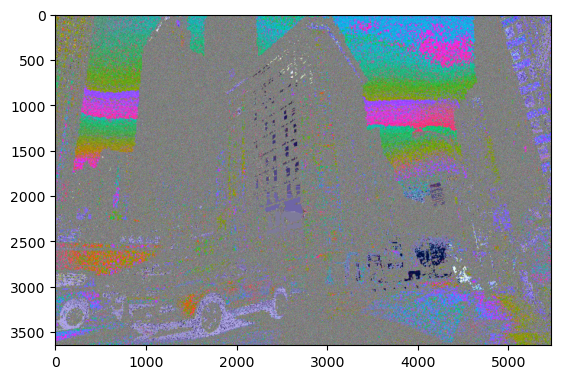

In [10]:
plt.imshow(img1_r)
plt.show()

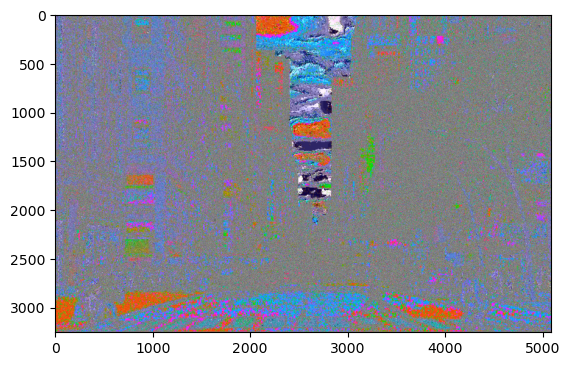

In [11]:
plt.imshow(img2_r)
plt.show()